In [1]:
import tensorflow as tf
from tqdm import tqdm_notebook, tnrange

### Open questions

- Is `tf.truncated_normal` good enough? Why others uses `random_normal_initializer` or `xavier_initializer`.
- Is `padding='VALID'` needed for first conv layer? what does that mean?
- Does training method matters (except for speed)?
- Typically data parallelism uses synchronized training across replica, because the GPU devices are the same, thus there's no issue about waiting the slowest device.
    + However, when training across network, when heteogeneous devices are used, how to determine async/sync?
    + Some mix between sync and async? like all devices with same power are sync, and devices with different power are async and only sync every several batches
    + In async, how gradients are merged? They are averaged in sync case
- Transfering data between GPUs are slower than between CPU and GPU? verify this.
    + source: https://www.tensorflow.org/versions/r0.11/tutorials/deep_cnn/index.html#training-a-model-using-multiple-gpu-cards



## Figures for some runs



In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

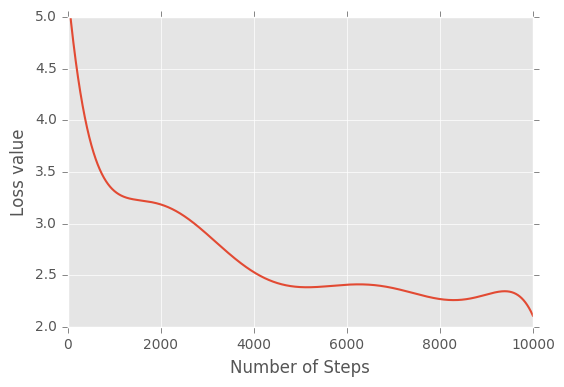

In [140]:
# PATTERN = 'loss = ([0-9.]+)'
pattern = re.compile(PATTERN)

with open('logs/k80-flowers/2gpu-model-data/out.log') as f:
    lines = f.readlines()
losses = [float(pattern.search(line).group(1)) for line in lines[1:] if pattern.search(line)]

# Smooth
x = range(len(losses))
smoothed_losses = np.poly1d(np.polyfit(x, losses, 7))(x)

#plt.plot(losses)[0].set_alpha(0.5)

plt.plot(smoothed_losses, alpha=1, linewidth=1.5)
plt.ylim(2, 5)
#plt.xlim(0, 5)
plt.xlabel('Number of Steps')
plt.ylabel('Loss value')
#plt.title('Loss')
plt.grid('on')

Average speed: 90.7937506249 examples / sec


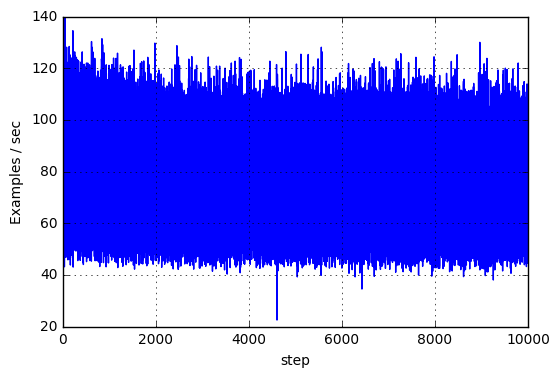

In [34]:
PATTERN = '([0-9.]+) examples'
pattern = re.compile(PATTERN)

with open('logs/k80-flowers/2gpu-model-data/out.log') as f:
    lines = f.readlines()
speeds = [float(pattern.search(line).group(1)) for line in lines[1:] if pattern.search(line)]

print('Average speed: {} examples / sec'.format(np.mean(speeds)))
plt.plot(speeds)
plt.grid('on')
plt.xlabel('step')
plt.ylabel('Examples / sec')

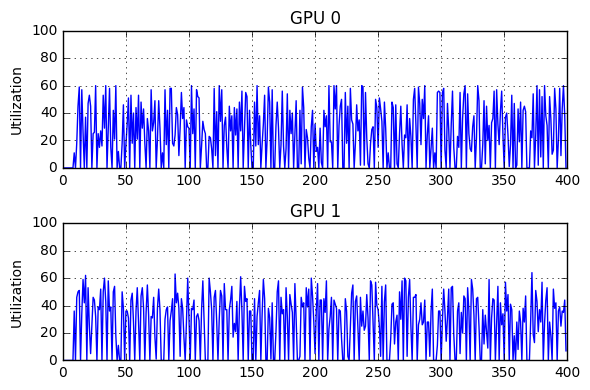

In [26]:
with open('logs/k80-flowers/2gpu-model-data/gpu.log') as f:
    lines = f.readlines()

def utilization(base, lines):    
    pattern = re.compile('(\\d+)%')
    lines = lines[base::21]
    return [float(pattern.search(line).group(1)) for line in lines]

gpu0 = utilization(8, lines)
gpu1 = utilization(11, lines)

gpu0 = gpu0[:400]
gpu1 = gpu1[:400]

plt.subplot('211')
plt.plot(gpu0)
plt.title('GPU 0')
plt.grid('on')
plt.ylabel('Utilization')
plt.ylim(0, 100)

plt.subplot('212')
plt.plot(gpu1)
plt.title('GPU 1')
plt.grid('on')
plt.ylabel('Utilization')
plt.ylim(0, 100)

plt.gcf().tight_layout()

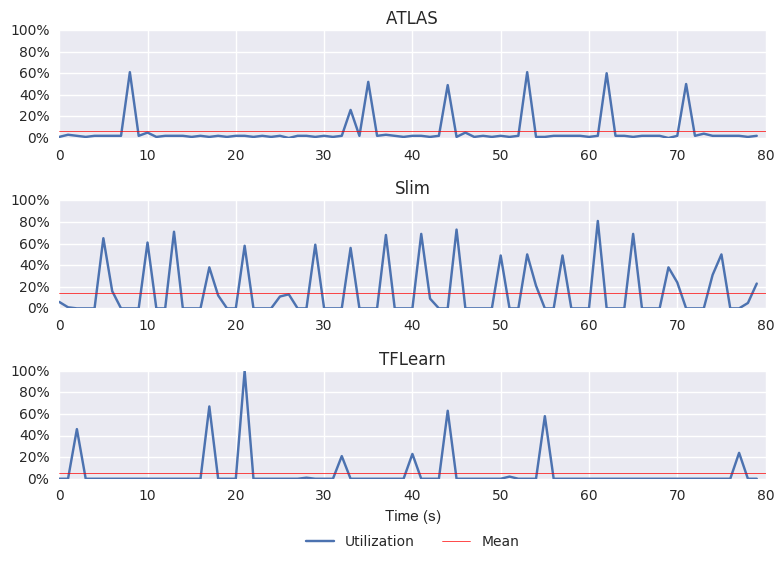

In [3]:
import seaborn
from matplotlib.ticker import FuncFormatter

def parse_1gpu(log_file):
    with open(log_file) as f:
        lines = f.readlines()

    def utilization(base, lines):    
        pattern = re.compile('(\\d+)%\s+Default')
        lines = lines[base::17]
        res = []
        for line in lines:
            match = pattern.search(line)
            if match:
                res.append(float(match.group(1)))
            else:
                print('Can not match line: ', line)
        return res
    return utilization(8, lines)

gpu_lvnguyen = parse_1gpu('logs/alex_lvnguyen.log')
gpu_slim = parse_1gpu('logs/alexnet_slim.log')
gpu_tflearn = parse_1gpu('logs/alex_tflearn.log')

xmax = 80
gpu_lvnguyen = gpu_lvnguyen[:xmax]
gpu_slim = gpu_slim[:xmax]
gpu_tflearn = gpu_tflearn[:xmax]


percentage_formatter = FuncFormatter(lambda x, pos: '{:.0f}%'.format(x))
#plt.plot(gpu_lvnguyen, display_name='lvnguyen')
#plt.plot(gpu_slim, display_name='slim')
#plt.plot(gpu_tflearn, display_name='tflearn')
#plt.grid('on')
#plt.legend('on')
#plt.ylim(0, 100)
#plt.xlim(0, 100)

ax = plt.subplot('311')
plt.plot(gpu_lvnguyen, label='Utilization')
plt.axhline(y=np.mean(gpu_lvnguyen), xmin=0, xmax=1, color='red', linewidth=0.5, label='Mean')
#plt.legend()
plt.gca().yaxis.set_major_formatter(percentage_formatter)
plt.title('ATLAS')
plt.grid('on')
plt.ylim(0, 100)
plt.xlim(0, xmax)

plt.subplot('312')
plt.plot(gpu_slim, label='Utilization')
plt.axhline(y=np.mean(gpu_slim), xmin=0, xmax=1, color='red', linewidth=0.5, label='Mean')
#plt.legend()
plt.gca().yaxis.set_major_formatter(percentage_formatter)
plt.title('Slim')
plt.grid('on')
plt.ylim(0, 100)
plt.xlim(0, xmax)

plt.subplot('313')
plt.plot(gpu_tflearn, label='Utilization')
plt.axhline(y=np.mean(gpu_tflearn), xmin=0, xmax=1, color='red', linewidth=0.5, label='Mean')
#plt.legend(loc='upper left')
plt.title('TFLearn')
plt.grid('on')
plt.gca().yaxis.set_major_formatter(percentage_formatter)
plt.xlabel('Time (s)')
plt.ylim(0, 100)
plt.xlim(0, xmax)

# Put a legend below current axis
plt.gca().legend(loc='upper center', bbox_to_anchor=(0.5, -.4),
          fancybox=True, shadow=True, ncol=5)

plt.gcf().tight_layout()

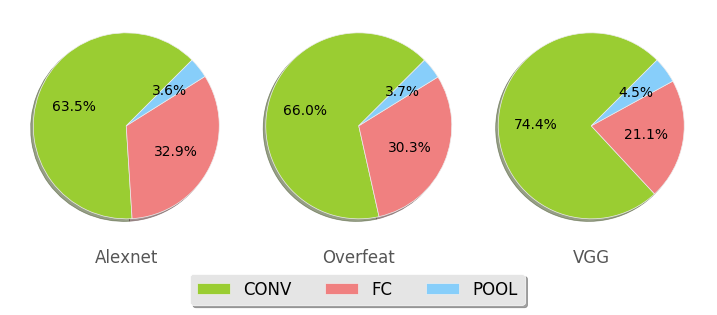

In [105]:
import pandas as pd
plt.style.use('ggplot')
df = pd.DataFrame.from_csv('/home/aetf/sync/M.S.Study/2016Fall/EECS582/project/report/layers.csv').transpose()

axs = df.plot.pie(subplots=True, colors=['yellowgreen', 'lightcoral', 'lightskyblue'], autopct='%1.1f%%',
                  legend=None, labels=None, shadow=True, startangle=45)

for ax, label in zip(axs, ['Alexnet', 'Overfeat', 'VGG']):
    ax.set_xlabel(label)
    ax.set_ylabel('')

#plt.gcf().tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# calculate dimensions of axes 1 in figure units
x0, y0, dx, dy = ax.get_position().bounds
maxd = max(dx, dy)
width = 6 * maxd / dx
height = 6 * maxd / dy

scale = 2
plt.gcf().set_size_inches((width/scale, height/scale))

plt.legend(['CONV', 'FC', 'POOL'], bbox_to_anchor=(0.25, -0.1),
          fancybox=True, shadow=True, ncol=3)

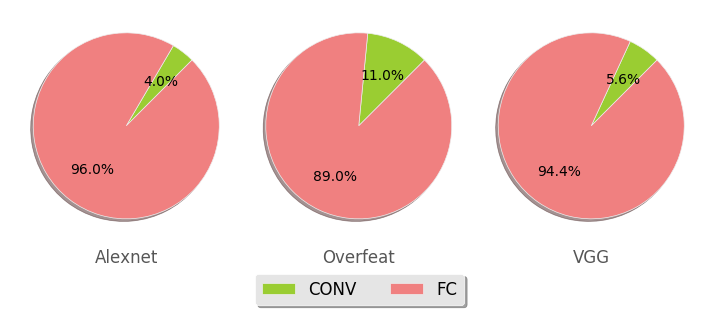

In [10]:
import pandas as pd
plt.style.use('ggplot')
df = pd.DataFrame.from_csv('/home/aetf/sync/M.S.Study/2016Fall/EECS582/project/report/weights.csv').transpose()

axs = df.plot.pie(subplots=True, colors=['yellowgreen', 'lightcoral', 'lightskyblue'], autopct='%1.1f%%',
                  legend=None, labels=None, shadow=True, startangle=45)

for ax, label in zip(axs, ['Alexnet', 'Overfeat', 'VGG']):
    ax.set_xlabel(label)
    ax.set_ylabel('')

#plt.gcf().tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# calculate dimensions of axes 1 in figure units
x0, y0, dx, dy = ax.get_position().bounds
maxd = max(dx, dy)
width = 6 * maxd / dx
height = 6 * maxd / dy

scale = 2
plt.gcf().set_size_inches((width/scale, height/scale))

plt.legend(['CONV', 'FC', 'POOL'], bbox_to_anchor=(-0.01, -0.1),
          fancybox=True, shadow=True, ncol=3)